In [1]:
# 1. Imports
import os, glob
import pandas as pd
import numpy as np
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from itertools import product
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import requests
import zipfile
import io
from pathlib import Path

In [5]:
# Step 1: Download and extract GitHub repo
url = "https://github.com/ravipeddi-05/EEN1072-ASSIGNMENT/archive/refs/heads/main.zip"
extract_to = "rnn_dataset"

response = requests.get(url)
with zipfile.ZipFile(io.BytesIO(response.content)) as zip_ref:
    zip_ref.extractall(extract_to)

# Step 2: Define base path to Geolife Trajectories
base_path = Path(extract_to) / "EEN1072-ASSIGNMENT-main" / "RNN dataset" / "Geolife Trajectories 1.3" / "Data"

# Step 3: Find all .plt files recursively
plt_files = list(base_path.glob("*/Trajectory/*.plt"))
print(f"✅ Found {len(plt_files)} .plt files in the dataset.")

# Step 4: Load each .plt file into a list of DataFrames
trajectories = []

for plt_file in plt_files:
    with open(plt_file, "r") as f:
        lines = f.readlines()[6:]  # skip first 6 header lines

    # Each line: lat, lon, 0, altitude, date, time
    data = [line.strip().split(",") for line in lines if line.strip()]
    df = pd.DataFrame(data, columns=["lat", "lon", "zero", "alt", "days", "date", "time"])
    df = df.astype({"lat": float, "lon": float, "alt": float})
    df["datetime"] = pd.to_datetime(df["date"] + " " + df["time"], format="%Y-%m-%d %H:%M:%S")

    trajectories.append({
        "user_id": plt_file.parts[-3],  # e.g., '000'
        "file": plt_file.name,
        "data": df[["lat", "lon", "alt", "datetime"]]
    })

print(f"✅ Parsed {len(trajectories)} trajectories into DataFrames.")

✅ Found 18670 .plt files in the dataset.
✅ Parsed 18670 trajectories into DataFrames.


In [2]:
# # 2. Read .plt trajectories
# BASE = "/kaggle/input/microsoft-geolife-gps-trajectory-dataset/Geolife Trajectories 1.3/Data"
# data = []
# for user in os.listdir(BASE):
#     traj_dir = os.path.join(BASE, user, "Trajectory")
#     if not os.path.isdir(traj_dir): continue
#     for f in os.listdir(traj_dir):
#         if not f.endswith(".plt"): continue
#         df = pd.read_csv(os.path.join(traj_dir, f), skiprows=6, header=None,
#                          names=["lat","lon","zero","alt","dayNo","date","time"])
#         df["uid"] = user
#         df["dt"] = pd.to_datetime(df["date"] + " " + df["time"], format="%Y-%m-%d %H:%M:%S", errors="coerce")
#         data.append(df[["uid","dt","lat","lon"]])
# df = pd.concat(data).dropna().reset_index(drop=True)
# df = df.sort_values(["uid","dt"]).reset_index(drop=True)

# # 3. Filter users with ≥11 points
# df = df.groupby("uid").filter(lambda x: len(x) >= 11)

In [3]:
# 4. Normalize coordinates
df["lat_n"] = (df["lat"] - df["lat"].min()) / (df["lat"].max() - df["lat"].min())
df["lon_n"] = (df["lon"] - df["lon"].min()) / (df["lon"].max() - df["lon"].min())


In [4]:
# 5. Sequence generation
SEQ = 10
X, y = [], []
for uid, g in df.groupby("uid"):
    arr = g[["lat_n","lon_n"]].values
    for i in range(len(arr) - SEQ):
        X.append(arr[i:i+SEQ])
        y.append(arr[i+SEQ])
X, y = np.array(X), np.array(y)

In [5]:
# 6. Train/Val/Test split
X_train, X_tmp, y_train, y_tmp = train_test_split(X, y, test_size=0.2, random_state=1)
X_val, X_test, y_val, y_test = train_test_split(X_tmp, y_tmp, test_size=0.5, random_state=1)

In [6]:
# 7. Dataset class
X, y = X[:10000], y[:10000]
class TD(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)
    def __len__(self):
        return len(self.X)
    def __getitem__(self, i):
        return self.X[i], self.y[i]

In [8]:
# 8. Model definition
class RNN(nn.Module):
    def __init__(self, h):
        super().__init__()
        self.lstm = nn.LSTM(2, h, batch_first=True)
        self.fc = nn.Linear(h, 2)
    def forward(self, x):
        _, (hn, _) = self.lstm(x)
        return self.fc(hn[-1])


In [9]:
# 🔧 Expanded datasets
X_train_small, y_train_small = X_train[:5000], y_train[:5000]
X_val_small, y_val_small = X_val[:1000], y_val[:1000]
X_test_small, y_test_small = X_test[:1000], y_test[:1000]

# 📦 DataLoader setup
train_loader = DataLoader(TD(X_train_small, y_train_small), batch_size=64, shuffle=True, num_workers=0)
val_loader = DataLoader(TD(X_val_small, y_val_small), batch_size=64, num_workers=0)
test_loader = DataLoader(TD(X_test_small, y_test_small), batch_size=64, num_workers=0)

# 🧠 Model setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = RNN(64).to(device)  # Hidden size = 64

# ⚙️ Training loop
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.MSELoss()

print("🚀 Training (no tuning, 10k samples)...")
for epoch in range(2):  # 5 epochs for balanced speed/performance
    model.train()
    total_loss = 0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        loss = loss_fn(model(xb), yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}, Train Loss: {total_loss / len(train_loader):.5f}")

# 📊 Final Evaluation
model.eval()
test_loss = 0
with torch.no_grad():
    for xb, yb in test_loader:
        xb, yb = xb.to(device), yb.to(device)
        test_loss += loss_fn(model(xb), yb).item()

final_mse = test_loss / len(test_loader)
print(f"\n✅ Final Test MSE (no tuning, 10k samples): {final_mse:.5f}")


🚀 Training (no tuning, 10k samples)...
Epoch 1, Train Loss: 0.05971
Epoch 2, Train Loss: 0.00154

✅ Final Test MSE (no tuning, 10k samples): 0.00140


In [10]:
param_grid = [(64, 32, 0.001)]  # Only one config

def ultra_fast_tune(param_grid, device):
    best_loss = float("inf")
    best_model = None

    for h, b, lr in param_grid:
        print(f"⚙️ Config: hidden={h}, batch={b}, lr={lr}")
        train_loader = DataLoader(TD(X_train[:2000], y_train[:2000]), batch_size=b, shuffle=True, num_workers=0)
        val_loader = DataLoader(TD(X_val[:500], y_val[:500]), batch_size=b, num_workers=0)

        model = RNN(h).to(device)
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
        loss_fn = nn.MSELoss()

        for epoch in range(2):  # ⏱️ Only 2 epochs
            model.train()
            for xb, yb in train_loader:
                xb, yb = xb.to(device), yb.to(device)
                optimizer.zero_grad()
                loss = loss_fn(model(xb), yb)
                loss.backward()
                optimizer.step()

        model.eval()
        val_loss = np.mean([
            loss_fn(model(xb.to(device)), yb.to(device)).item()
            for xb, yb in val_loader
        ])
        print(f"📉 Val MSE: {val_loss:.5f}")

        if val_loss < best_loss:
            best_loss = val_loss
            best_model = model

    return best_model

# 🔁 Train
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
best_model = ultra_fast_tune(param_grid, device)

# 🧪 Quick test on limited samples
test_loader = DataLoader(TD(X_test[:500], y_test[:500]), batch_size=32, num_workers=0)
best_model.eval()
test_loss = np.mean([
    nn.MSELoss()(best_model(xb.to(device)), yb.to(device)).item()
    for xb, yb in test_loader
])
print(f"\n✅ Final (Quick) Test MSE: {test_loss:.5f}")


⚙️ Config: hidden=64, batch=32, lr=0.001
📉 Val MSE: 0.00162

✅ Final (Quick) Test MSE: 0.00092



Trajectory 1:
  Point 1: lat=0.097581, lon=0.823369
  Point 2: lat=0.097581, lon=0.823368
  Point 3: lat=0.097581, lon=0.823369
  Point 4: lat=0.097581, lon=0.823368
  Point 5: lat=0.097582, lon=0.823368
  Point 6: lat=0.097582, lon=0.823368
  Point 7: lat=0.097582, lon=0.823368
  Point 8: lat=0.097583, lon=0.823368
  Point 9: lat=0.097583, lon=0.823368
  Point 10: lat=0.097583, lon=0.823369


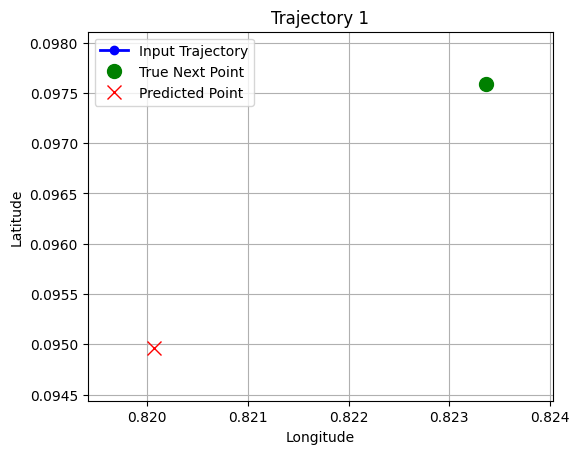


Trajectory 2:
  Point 1: lat=0.097753, lon=0.823345
  Point 2: lat=0.097753, lon=0.823345
  Point 3: lat=0.097753, lon=0.823345
  Point 4: lat=0.097752, lon=0.823345
  Point 5: lat=0.097752, lon=0.823345
  Point 6: lat=0.097752, lon=0.823345
  Point 7: lat=0.097752, lon=0.823345
  Point 8: lat=0.097751, lon=0.823345
  Point 9: lat=0.097751, lon=0.823345
  Point 10: lat=0.097751, lon=0.823345


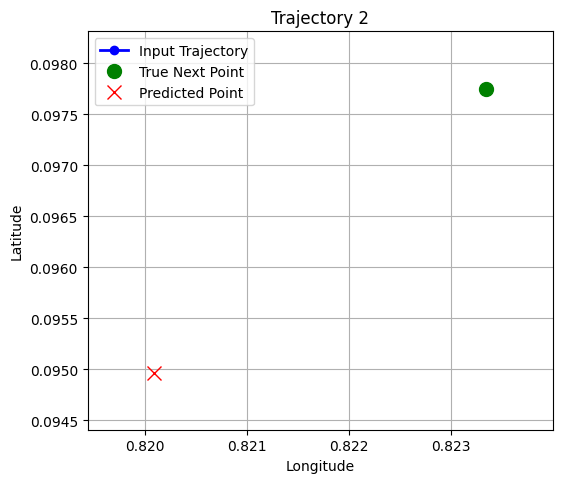


Trajectory 3:
  Point 1: lat=0.097354, lon=0.823275
  Point 2: lat=0.097354, lon=0.823275
  Point 3: lat=0.097354, lon=0.823275
  Point 4: lat=0.097354, lon=0.823275
  Point 5: lat=0.097354, lon=0.823275
  Point 6: lat=0.097355, lon=0.823275
  Point 7: lat=0.097355, lon=0.823275
  Point 8: lat=0.097355, lon=0.823275
  Point 9: lat=0.097355, lon=0.823274
  Point 10: lat=0.097355, lon=0.823274


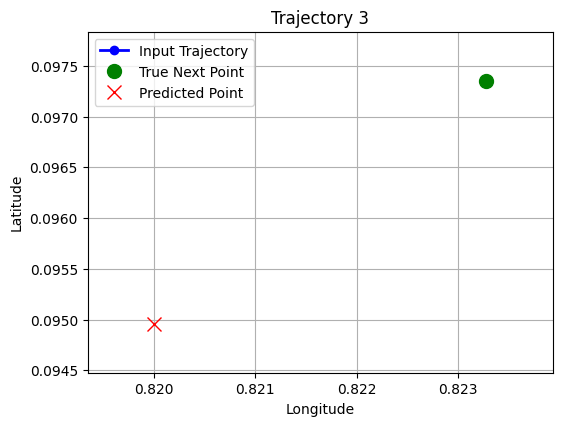


Trajectory 4:
  Point 1: lat=0.114194, lon=0.846985
  Point 2: lat=0.114194, lon=0.846985
  Point 3: lat=0.114194, lon=0.846985
  Point 4: lat=0.114194, lon=0.846985
  Point 5: lat=0.114194, lon=0.846985
  Point 6: lat=0.114194, lon=0.846985
  Point 7: lat=0.114194, lon=0.846985
  Point 8: lat=0.114194, lon=0.846985
  Point 9: lat=0.114194, lon=0.846985
  Point 10: lat=0.114194, lon=0.846985


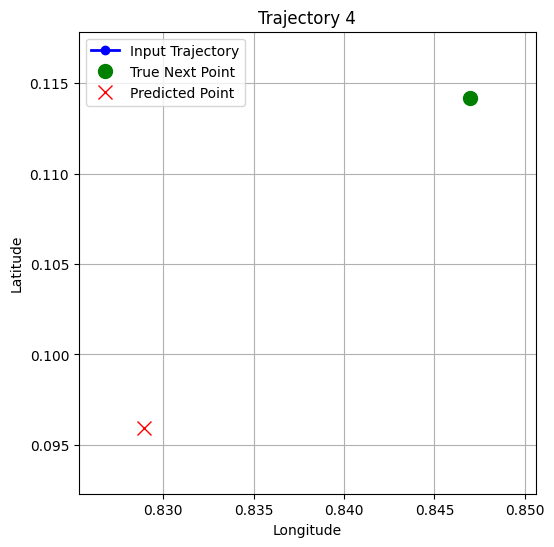


Trajectory 5:
  Point 1: lat=0.097574, lon=0.823194
  Point 2: lat=0.097573, lon=0.823194
  Point 3: lat=0.097573, lon=0.823194
  Point 4: lat=0.097573, lon=0.823194
  Point 5: lat=0.097573, lon=0.823194
  Point 6: lat=0.097573, lon=0.823194
  Point 7: lat=0.097573, lon=0.823194
  Point 8: lat=0.097573, lon=0.823194
  Point 9: lat=0.097574, lon=0.823194
  Point 10: lat=0.097574, lon=0.823194


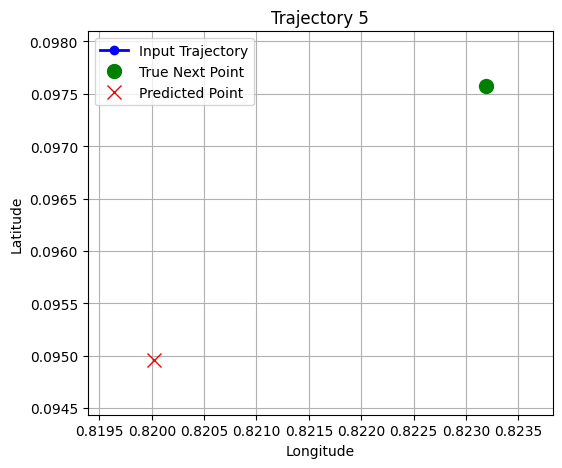

In [15]:
import matplotlib.pyplot as plt
import numpy as np

# Step 1: Load a batch
for xb, yb in tl:
    xb, yb = xb.to(device), yb.to(device)
    preds = best_model(xb).cpu().detach().numpy()
    xb, yb = xb.cpu().numpy(), yb.cpu().numpy()
    break  # first batch only

# Step 2: Visualize first 5 sequences
for i in range(5):
    lat_seq = xb[i, :, 0]  # Latitude
    lon_seq = xb[i, :, 1]  # Longitude

    # Debug: print trajectory coordinates
    print(f"\nTrajectory {i+1}:")
    for j in range(len(lat_seq)):
        print(f"  Point {j+1}: lat={lat_seq[j]:.6f}, lon={lon_seq[j]:.6f}")

    true_lat, true_lon = yb[i, 0], yb[i, 1]
    pred_lat, pred_lon = preds[i, 0], preds[i, 1]

    plt.figure(figsize=(6, 6))

    # 🌀 Plot the past trajectory
    plt.plot(lon_seq, lat_seq, 'o-', label="Input Trajectory", color='blue', linewidth=2, markersize=6)

    # ✅ True next point (green)
    plt.plot(true_lon, true_lat, 'go', label="True Next Point", markersize=10)

    # ❌ Predicted point (red)
    plt.plot(pred_lon, pred_lat, 'rx', label="Predicted Point", markersize=10)

    # 📐 Fix aspect and limits
    plt.gca().set_aspect('equal', adjustable='box')
    plt.title(f"Trajectory {i+1}")
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.legend()
    plt.grid(True)

    # Dynamic padding around all points
    all_lats = np.concatenate([lat_seq, [true_lat, pred_lat]])
    all_lons = np.concatenate([lon_seq, [true_lon, pred_lon]])
    padding_lat = (all_lats.max() - all_lats.min()) * 0.2 or 0.0005
    padding_lon = (all_lons.max() - all_lons.min()) * 0.2 or 0.0005

    plt.xlim(all_lons.min() - padding_lon, all_lons.max() + padding_lon)
    plt.ylim(all_lats.min() - padding_lat, all_lats.max() + padding_lat)

    plt.show()
